In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\aditya\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def create_placeholders():
    X=tf.placeholder(tf.float32,[None,28,28,1])
    Y=tf.placeholder(tf.float32,[None,10])
    return X,Y

In [5]:
def make_params():
    w1=tf.get_variable('w1',[5,5,1,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    w2=tf.get_variable('w2',[5,5,16,32],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    w3=tf.get_variable('w3',[5,5,32,64],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters={'w1':w1,'w2':w2,'w3':w3}
    return parameters

In [6]:
def for_prop(xtr,params):
    w1=params['w1']
    w2=params['w2']
    w3=params['w3']
    nx=xtr
    nx=tf.nn.conv2d(nx,w1,strides=[1,1,1,1],padding='SAME')
    nx=tf.nn.relu(nx)
    nx=tf.nn.max_pool(nx,ksize=[1,3,3,1],strides=[1,1,1,1],padding='VALID')
    nx=tf.nn.conv2d(nx,w2,strides=[1,1,1,1],padding='VALID')
    nx=tf.nn.relu(nx)
    nx=tf.nn.max_pool(nx,ksize=[1,3,3,1],strides=[1,1,1,1],padding='VALID')
    nx=tf.nn.conv2d(nx,w3,strides=[1,1,1,1],padding='VALID')
    nx=tf.nn.relu(nx)
    nx=tf.nn.max_pool(nx,ksize=[1,3,3,1],strides=[1,1,1,1],padding='VALID')
    nx=tf.contrib.layers.flatten(nx)
    nx=tf.contrib.layers.fully_connected(nx,10,activation_fn=None)
    return nx

In [7]:
def compute_cost(logits,labels):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [8]:
def random_mini_batches(xtr,ytr,mbs):
    m=xtr.shape[0]
    perm=list(np.random.permutation(m))
    xtr=xtr[perm,:,:,:]
    ytr=ytr[perm,:]
    num_tot_mb=m//mbs
    minibatches=[]
    for i in range(num_tot_mb):
        mbx=xtr[i*mbs:(i+1)*mbs,:,:,:]
        mby=ytr[i*mbs:(i+1)*mbs,:]
        mb=(mbx,mby)
        minibatches.append(mb)
    if m%mbs!=0:
        mbx=xtr[num_tot_mb*mbs:m,:,:,:]
        mby=ytr[num_tot_mb*mbs:m,:]
        mb=(mbx,mby)
        minibatches.append(mb)
    return minibatches

In [9]:
def accuracy(zf,ytr):
    y_pred=np.argmax(zf,axis=1)
    acc=np.mean(y_pred==ytr)
    return acc

In [10]:
df=pd.read_csv('./datasets/fashion-mnist_train.csv')
train_data=df.as_matrix()
xtr=train_data[:,1::]
ytr=train_data[:,0].reshape(60000,1)
print(xtr.shape)
print(ytr.shape)
xtr=xtr.reshape(60000,28,28,1)
print(xtr.shape)
ytroh=tf.one_hot(ytr,10,axis=1)
with tf.Session() as sess:
    ytroh=sess.run(ytroh).reshape(60000,10)
print(ytroh.shape)

(60000, 784)
(60000, 1)
(60000, 28, 28, 1)
(60000, 10)


In [14]:
newx=xtr[0:100,:,:,:]
newy=ytr[0:100,:]

In [43]:
def train(xtr,ytr,epochs=5,lr=0.001,batch_size=64):
    X,Y=create_placeholders()
    params=make_params()
    zf=for_prop(X,params)
    cost=compute_cost(zf,Y)
    optimizer=tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        costs=[]
        for i in range(epochs):
            epoch_cost=0
            minibatches=random_mini_batches(xtr,ytr,batch_size)
            m=xtr.shape[0]
            num_tot_mb=m//batch_size
            for mb in minibatches:
                mbx,mby=mb
                _,c=sess.run([optimizer,cost],feed_dict={X:mbx,Y:mby})
                epoch_cost+=c/num_tot_mb
            costs.append(epoch_cost)
            print('cost after epoch '+str(i)+':'+str(epoch_cost))
        final_params=sess.run(params)
        accuracy_list=[]
        minibatches=random_mini_batches(xtr,ytr,batch_size)
        for mb in minibatches:
            mbx,mby=mb
            m=mbx.shape[0]
            test_fz=sess.run(zf,feed_dict={X:mbx})
            test_fz=tf.argmax(test_fz,1)
            test_fz=sess.run(test_fz)
            test_fz=test_fz.reshape(m,1)
            mby=(np.argmax(mby,1)).reshape(m,1)
            acc=np.mean(test_fz==mby)
            accuracy_list.append(acc)
        accuracy_list=np.mean(accuracy_list)
        print('accuracy is---'+str(accuracy_list))
    plt.plot(np.squeeze(costs))
    plt.xlabel('epochs in 5s')
    plt.ylabel('cost')
    plt.title('cost vs epochs')    
    return(final_params,test_fz,newy)

cost after epoch 0:1.1750965693780702
cost after epoch 1:0.41409544138637366
cost after epoch 2:0.37512649301530987
cost after epoch 3:0.3814415371198532
cost after epoch 4:0.3485273541832936
accuracy is---0.8857276119402985


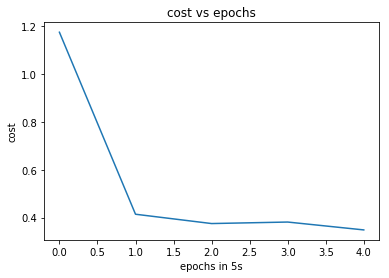

In [44]:
tf.reset_default_graph()
params,zf,ny=train(xtr,ytroh)